# Non-Fungible Tokens: Empirical Asset Pricing with Machine Learning

## Setup

In [121]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import date, timedelta
from sklearn import preprocessing
from skopt import BayesSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RepeatedKFold, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error,r2_score
import statsmodels.api as sm


import warnings
warnings.filterwarnings("ignore")

## Data Extraction

In [2]:
# Excel
df_trends = pd.read_excel('data/google_trends.xlsx', usecols=lambda x: 'Unnamed' not in x) 
df_tokens = pd.read_excel('data/df_tokens.xlsx', usecols=lambda x: 'Unnamed' not in x) 
df_collection = pd.read_excel('data/nonfungible-art-blocks.xlsx', usecols=lambda x: 'Unnamed' not in x) 
df_market = pd.read_excel('data/nonfungible-market.xlsx', usecols=lambda x: 'Unnamed' not in x) 

# CSV
df_provenance = pd.read_csv('data/df_provenance.csv', usecols=lambda x: 'Unnamed' not in x) 
df_traits = pd.read_csv('data/df_traits.csv', usecols=lambda x: 'Unnamed' not in x) 
df_txn = pd.read_csv('data/df_txn.csv', usecols=lambda x: 'Unnamed' not in x) 
df_eth = pd.read_csv('data/ETH-USD.csv', usecols=lambda x: 'Unnamed' not in x) 
df_tokens_minted = pd.read_csv('data/tokens_minted.csv', usecols=lambda x: 'Unnamed' not in x)

## Data Preparation

In [3]:
# Get transactions
df_transactions = df_provenance.merge(df_txn, how='inner', left_on=['txHash'], right_on=['hash'], suffixes=('', ''),indicator=False)
df_transactions.rename(columns={"value": "price","date":"DATETIME"},inplace=True)

# Drop duplicates
df_transactions.drop_duplicates(inplace=True)

# Get eth price and volume traded
df_transactions['DATETIME'] = pd.to_datetime(df_transactions['DATETIME'], infer_datetime_format=True)
df_transactions['DATE'] = df_transactions['DATETIME'].dt.date
df_transactions['DATE'] = pd.to_datetime(df_transactions['DATE'], infer_datetime_format=True)

df_eth.rename(columns={"Close": "ETH_CLOSE_PRICE", "Volume": "ETH_TRADED_VOLUME"},inplace=True)
df_eth['Date'] = pd.to_datetime(df_eth['Date'])

df_transactions = df_transactions.merge(df_eth[['Date','ETH_CLOSE_PRICE','ETH_TRADED_VOLUME']], how='left', left_on=['DATE'], right_on=['Date'], suffixes=('', ''),indicator=False)
df_transactions.drop(columns=['Date'],inplace=True)


# Get interest score
df_trends['DATE'] = pd.to_datetime(df_trends['DATE'])
df_transactions = df_transactions.merge(df_trends[['DATE','INTEREST_SCORE_NFT','INTEREST_SCORE_ARTBLOCKS']], how='left', left_on=['DATE'], right_on=['DATE'], suffixes=('', ''),indicator=False)


# Get market data
df_market['DateTime'] = pd.to_datetime(df_market['DateTime'])
df_transactions = df_transactions.merge(df_market[['DateTime', 'Number of sales', 'Sales USD', 'Active market wallets',
       'Unique buyers', 'Unique sellers']], how='left', left_on=['DATE'], right_on=['DateTime'], suffixes=('', ''),indicator=False)
df_transactions.drop(columns=['DateTime'],inplace=True)


# Get collection active market wallets
df_collection['DateTime'] = pd.to_datetime(df_collection['DateTime'])
df_transactions = df_transactions.merge(df_collection[['DateTime', 'Active market wallets','Unique buyers', 'Unique sellers']], how='left', left_on=['DATE'], right_on=['DateTime'], suffixes=('', ' collection'),indicator=False)
df_transactions.drop(columns=['DateTime'],inplace=True)


# Get tokens minted
df_tokens_minted['evt_block_time'] = pd.to_datetime(df_tokens_minted['evt_block_time'])
tokens_minted_dt = pd.date_range(df_tokens_minted.evt_block_time.min(),df_tokens_minted.evt_block_time.max()-timedelta(days=1),freq='d')
tokens_minted_df_dt = pd.DataFrame(tokens_minted_dt,columns=['dt'])
df_tokens_minted = tokens_minted_df_dt.merge(df_tokens_minted, how='left', left_on=['dt'], right_on=['evt_block_time'], suffixes=('', ''),indicator=False)
df_tokens_minted.sort_values(by='dt', ascending=True,inplace=True)
df_tokens_minted.fillna(0,inplace=True)
df_tokens_minted['tokens_available'] = df_tokens_minted.tokens_minted.cumsum()
df_transactions = df_transactions.merge(df_tokens_minted, how='left', left_on=['DATE'], right_on=['dt'], suffixes=('', ''),indicator=False)
df_transactions.drop(columns=['evt_block_time','dt'],inplace=True)


# Add Action category
df_transactions.loc[df_transactions['from'] == '0x0000000000000000000000000000000000000000','Action'] = 'Mint'
df_transactions.loc[(df_transactions['price'] == 0)&(df_transactions['from'] != '0x0000000000000000000000000000000000000000'),'Action'] = 'Transfer'
df_transactions.loc[(df_transactions['price'] > 0)&(df_transactions['from'] != '0x0000000000000000000000000000000000000000'),'Action'] = 'Sale'


# Add bundle transactions flag
df_bundles = df_transactions.groupby('hash', as_index=False)[['collectionTokenId','price']].nunique()
df_bundles = df_bundles[(df_bundles['collectionTokenId']>1)&(df_bundles['price'])==1]
df_bundles['is_bundle'] = 1
df_bundles['nb_tokens_bundle'] = df_bundles['collectionTokenId']

df_transactions = df_transactions.merge(df_bundles[['hash','is_bundle','nb_tokens_bundle']], how='left', left_on=['hash'], right_on=['hash'], suffixes=('', ''),indicator=False)
df_transactions['is_bundle'] = df_transactions['is_bundle'].fillna(0)

df_transactions.loc[(df_transactions['is_bundle'] == 1)&(df_transactions['Action'] == 'Sale'),'price'] = df_transactions['price']/df_transactions['nb_tokens_bundle']
df_transactions.drop(columns=['nb_tokens_bundle'],inplace=True)


# Add collection volume and sales
df_sales = df_transactions[df_transactions['Action'] == 'Sale']
df_sales_ = df_sales.groupby('DATE', as_index=False)[['DATE','price','hash']].agg({"price": np.sum,"hash": lambda x: x.nunique()})

df_sales_['Transactions collection ETH'] = df_sales_['price']
df_sales_['Number of Transactions collection'] = df_sales_['hash']
df_sales_['Action'] = 'Sale'

df_transactions = df_transactions.merge(df_sales_[['DATE','Transactions collection ETH','Number of Transactions collection','Action']], how='left', left_on=['DATE','Action'], right_on=['DATE','Action'], suffixes=('', ''),indicator=False)
df_transactions['Transactions collection USD'] = df_transactions['ETH_CLOSE_PRICE']*df_transactions['Transactions collection ETH']


In [4]:
### TRAITS ###
df_traits.fillna('None',inplace=True)
df_traits_tt = df_traits.groupby('collectionTokenId', as_index=False)[['trait_type','value']].agg({"trait_type": lambda x: x.nunique(),"value": lambda x: x.nunique()})
df_traits_tt.rename(columns={"trait_type": "number_trait_types", "value": "number_trait_values"},inplace=True)


df_traits_t = df_traits.groupby('value', as_index=False)[['collectionTokenId']].nunique()
df_traits_t.rename(columns={"collectionTokenId": "number_tokens_trait_value"},inplace=True)
df_traits_t.sort_values('number_tokens_trait_value', ascending=True, inplace=True)
#df_traits_t['rank_rarity_trait_value'] = df_traits_t['number_tokens_trait_value'].rank(ascending=True,pct=True)
df_traits_t['rarity_trait_value'] = df_traits_t['number_tokens_trait_value']/df_traits_t['number_tokens_trait_value'].sum()
df_traits_t['rarity_trait_value'] = df_traits_t['rarity_trait_value']*100


df_traits_ty = df_traits.groupby('trait_type', as_index=False)[['collectionTokenId']].nunique()
df_traits_ty.rename(columns={"collectionTokenId": "number_tokens_trait_type"},inplace=True)
df_traits_ty.sort_values('number_tokens_trait_type', ascending=True, inplace=True)
#df_traits_ty['rank_rarity_trait_type'] = df_traits_ty['number_tokens_trait_type'].rank(ascending=True,pct=True)
df_traits_ty['rarity_trait_type'] = df_traits_ty['number_tokens_trait_type']/df_traits_ty['number_tokens_trait_type'].sum()
df_traits_ty['rarity_trait_type'] = df_traits_ty['rarity_trait_type']*100


df_traits_ = df_traits.merge(df_traits_t, how='left', left_on=['value'], right_on=['value'], suffixes=('', ''),indicator=False)
df_traits_ = df_traits_.groupby(['collectionTokenId','trait_type'], as_index=False)[['rarity_trait_value']].mean()
df_traits_ = df_traits_.merge(df_traits_tt[['collectionTokenId','number_trait_values']], how='left', on=['collectionTokenId'], suffixes=('', ''),indicator=False)
df_traits_final = df_traits_.merge(df_traits_ty[['trait_type','rarity_trait_type']], how='left', on=['trait_type'], suffixes=('', ''),indicator=False)


In [5]:
# Create final transaction set
df_transactions_final = df_transactions.merge(df_traits_final, how='left', on=['collectionTokenId'], suffixes=('', ''),indicator=False)

# Fill missing values
df_transactions_final['rarity_trait_type'] = df_transactions_final['rarity_trait_type'].fillna(df_traits_final[df_traits_final['trait_type'] =='None']['rarity_trait_type'].min())
df_transactions_final['number_trait_values'] = df_transactions_final['number_trait_values'].fillna(0)
df_transactions_final['trait_type'] = df_transactions_final['trait_type'].fillna('None')
df_transactions_final['rarity_trait_value'] = df_transactions_final['rarity_trait_value'].fillna(df_traits_final[df_traits_final['trait_type'] =='None']['rarity_trait_value'].min())

# Filter dataset by date
df_transactions_final = df_transactions_final[df_transactions_final['DATE']<pd.to_datetime('2022-07-01')]
df_transactions_final.reset_index(drop=True,inplace=True)


In [6]:
df_transactions_final.isnull().sum()

blockNumber                               0
DATETIME                                  0
from                                      0
to                                        0
txHash                                    0
collectionTokenId                         0
hash                                      0
price                                     0
gasPrice                                  0
gas                                       0
DATE                                      0
ETH_CLOSE_PRICE                           0
ETH_TRADED_VOLUME                         0
INTEREST_SCORE_NFT                        0
INTEREST_SCORE_ARTBLOCKS                  0
Number of sales                           0
Sales USD                                 0
Active market wallets                     0
Unique buyers                             0
Unique sellers                            0
Active market wallets collection          0
Unique buyers collection                  0
Unique sellers collection       

In [7]:
print(df_transactions_final.DATE.min(),df_transactions_final.DATE.max())

2020-12-12 00:00:00 2022-06-30 00:00:00


In [8]:
# Create final sales dataset
df_sales_final = df_transactions_final[df_transactions_final['Action']=='Sale']
df_sales_final.reset_index(drop=True,inplace=True)
print(df_sales_final.DATE.min(),df_sales_final.DATE.max())
#df_sales_final

## Add NFT metrics to sales dataframe

df_sales_final['transaction_order'] = df_sales_final.sort_values(['DATETIME'], ascending=True) \
             .groupby(['collectionTokenId']) \
             .cumcount() + 1

df_sales_final_rn = df_sales_final[['DATETIME','collectionTokenId','price','transaction_order']]

df_sales_final_rn['transaction_order'] = df_sales_final_rn['transaction_order'] + 1

df_sales_final = df_sales_final.merge(df_sales_final_rn, how='left', on=['collectionTokenId','transaction_order'], 
                                   suffixes=('', '_previous'),indicator=False)

df_mint = df_transactions_final[df_transactions_final['Action']=='Mint'][['DATETIME','collectionTokenId','price']]
df_sales_final = df_sales_final.merge(df_mint, how='left', on=['collectionTokenId'], 
                                   suffixes=('', '_mint'),indicator=False)

df_first = df_sales_final[df_sales_final['transaction_order']==1][['DATETIME','collectionTokenId','price']]
df_sales_final = df_sales_final.merge(df_first, how='left', on=['collectionTokenId'], 
                                   suffixes=('', '_first_txn'),indicator=False)

# Missing values
df_sales_final.loc[df_sales_final.DATETIME_mint.isnull()==True,'DATETIME_mint'] = df_sales_final['DATETIME_first_txn']
df_sales_final.loc[df_sales_final.price_mint.isnull()==True,'price_mint'] = df_sales_final['price_first_txn']

df_sales_final.loc[df_sales_final.DATETIME_previous.isnull()==True,'DATETIME_previous'] = df_sales_final['DATETIME_mint']
df_sales_final.loc[df_sales_final.price_previous.isnull()==True,'price_previous'] = df_sales_final['price_mint']


# Create metrics
df_sales_final['days_since_last_transaction'] = (df_sales_final['DATETIME'] - df_sales_final['DATETIME_previous']).dt.days
df_sales_final['days_since_mint'] = (df_sales_final['DATETIME'] - df_sales_final['DATETIME_mint']).dt.days

# Drop redundant columns
df_sales_final.drop(columns=['DATETIME_previous','DATETIME_mint','DATETIME_first_txn','price_mint','price_first_txn'],inplace=True)


# Add average price per trait type (project)
df_tt_price = df_sales_final[['trait_type','price']].groupby('trait_type', as_index=False).mean()

df_sales_final = df_sales_final.merge(df_tt_price, how='left', on=['trait_type'], 
                                   suffixes=('', '_avg_trait_type'),indicator=False)

# Label encoding
def encode_features(df,s):
    le = preprocessing.OrdinalEncoder()
    le.fit(df[[s]].astype(str))
    df['CD_'+s] = le.transform(df[[s]].astype(str))
    
    return le

lec = encode_features(df_sales_final,'trait_type')

2020-12-13 00:00:00 2022-06-30 00:00:00


In [9]:
df_sales_final

,blockNumber,DATETIME,from,to,txHash,collectionTokenId,hash,price,gasPrice,gas,...,trait_type,rarity_trait_value,number_trait_values,rarity_trait_type,transaction_order,price_previous,days_since_last_transaction,days_since_mint,price_avg_trait_type,CD_trait_type
0,14111596,2022-01-31 04:52:12+00:00,0xFC54c527bf835d7998F3e0E90B08a00DE7146B05,0x224b3F081075c1bC10e8FCE9C03719214F714e23,0xf761f50d549ef75a3da8d69720fee6f8d83cef1eb737...,100000001,0xf761f50d549ef75a3da8d69720fee6f8d83cef1eb737...,4.00,9.552986e-08,3.108360e-13,...,CENTURY,0.023393,13.0,0.557760,1,0.10,219,219,2.894456,45.0
1,13148693,2021-09-02 21:21:35+00:00,0x62223651d6a33D58Be70Eb9876c3CaF7096169ef,0x91005D8717194308f140Df0f76F352cCD6A2C61A,0x759d61fe72030a44aa5fff99b3774ae8a89c8b3336df...,100000002,0x759d61fe72030a44aa5fff99b3774ae8a89c8b3336df...,7.50,1.156654e-07,3.468240e-13,...,CENTURY,0.024450,13.0,0.557760,1,0.10,69,69,2.894456,45.0
2,13261304,2021-09-20 07:37:21+00:00,0x91005D8717194308f140Df0f76F352cCD6A2C61A,0x55FaF0e5E6e532b1C5799bDEec1A0F193E54a92D,0xe6de34b305a4a408374ba099524cf8c081bd4231c044...,100000002,0xe6de34b305a4a408374ba099524cf8c081bd4231c044...,6.90,6.772837e-08,3.106900e-13,...,CENTURY,0.024450,13.0,0.557760,2,7.50,17,86,2.894456,45.0
3,12924275,2021-07-30 02:00:33+00:00,0x62223651d6a33D58Be70Eb9876c3CaF7096169ef,0x1bB77204B2ED64751138145C26a6b31E836DdCdb,0x80fd5e8c5909ce4a61c239f1b08024b4158b956ba1bf...,100000003,0x80fd5e8c5909ce4a61c239f1b08024b4158b956ba1bf...,1.50,3.700000e-08,2.349380e-13,...,CENTURY,0.030092,13.0,0.557760,1,0.10,34,34,2.894456,45.0
4,12923411,2021-07-29 22:42:14+00:00,0x62223651d6a33D58Be70Eb9876c3CaF7096169ef,0x65Ba4f92D7DFA813DdBd849D9Faf38a723Dd9b12,0x222d38ea3e3a5a661b202adb0e4e9fc5943ebfe1cd96...,100000004,0x222d38ea3e3a5a661b202adb0e4e9fc5943ebfe1cd96...,1.60,3.490000e-08,2.351920e-13,...,CENTURY,0.025592,13.0,0.557760,1,0.10,34,34,2.894456,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148886,12248374,2021-04-16 02:10:04+00:00,0xa3bEDEaBc56c226DF5ac4755e182308B08C166ed,0xb9bc87e399E371100F83ffC51ED44c13DAF576cE,0x50bb4f1dbee56bf42bb016d9fb4669e1b9f9dbb9a33a...,20000049,0x50bb4f1dbee56bf42bb016d9fb4669e1b9f9dbb9a33a...,0.53,1.300000e-07,2.522210e-13,...,Sentience,0.006925,5.0,0.085809,1,0.15,59,59,2.082499,221.0
148887,13150694,2021-09-03 04:55:35+00:00,0x947AC690b32290E4535AC342D25A65a01125a544,0xa7b9c7CB5dfaf482Ce2d3166b955E685e080cBbc,0x919bda8a6da4fa9089a3bc26bebde627d6a29ebc1430...,20000049,0x919bda8a6da4fa9089a3bc26bebde627d6a29ebc1430...,4.00,1.195131e-07,3.431990e-13,...,Sentience,0.006925,5.0,0.085809,2,0.53,140,199,2.082499,221.0
148888,12724236,2021-06-28 18:55:37+00:00,0x6717aF6CeF0AC26999EEc6484Ed213C9fF81a257,0x40b767D119dbC81547cC13C6c55B6eD40A6506F1,0x9140fc8204a611d42e2f711f06c85fd115bc5cf0c5ca...,20000050,0x9140fc8204a611d42e2f711f06c85fd115bc5cf0c5ca...,1.50,2.100000e-08,2.349500e-13,...,Sentience,0.004971,5.0,0.085809,1,0.15,132,132,2.082499,221.0
148889,11866212,2021-02-16 06:32:59+00:00,0x703020140a80DB59cc3cB594004CEdCDb5e54E67,0xf0f0682600EEA116A1A15AB0e9c0311B7Dbaf41A,0xb45ded60429f60c5c52886cee7eb5af4f91dfaf1a03d...,20000053,0xb45ded60429f60c5c52886cee7eb5af4f91dfaf1a03d...,0.35,1.130000e-07,2.157160e-13,...,Sentience,0.016464,5.0,0.085809,1,0.15,0,0,2.082499,221.0


In [10]:
df_sales_final.isnull().sum()

blockNumber                          0
DATETIME                             0
from                                 0
to                                   0
txHash                               0
collectionTokenId                    0
hash                                 0
price                                0
gasPrice                             0
gas                                  0
DATE                                 0
ETH_CLOSE_PRICE                      0
ETH_TRADED_VOLUME                    0
INTEREST_SCORE_NFT                   0
INTEREST_SCORE_ARTBLOCKS             0
Number of sales                      0
Sales USD                            0
Active market wallets                0
Unique buyers                        0
Unique sellers                       0
Active market wallets collection     0
Unique buyers collection             0
Unique sellers collection            0
tokens_minted                        0
tokens_available                     0
Action                   

___________________

## Data Visualization

In [11]:
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import plotly.express as px
from plotly.subplots import make_subplots
from pandas_profiling import ProfileReport
import plotly.io as pio
pio.templates
%matplotlib inline

subPlots_Title_fontSize = 12
subPlots_xAxis_fontSize = 10
subPlots_yAxis_fontSize = 10
subPlots_label_fontSize = 10
heatmaps_text_fontSize = 14

plots_Title_fontSize = 28
plots_Title_textColour = 'black'

plots_Legend_fontSize = 15
plots_Legend_textColour = 'black'

plots_barTexts_fontSize = 8

In [12]:
# Get profiling report
cols = ['blockNumber', 'DATETIME','collectionTokenId',
       'price', 'gasPrice', 'gas', 'DATE', 'ETH_CLOSE_PRICE',
       'ETH_TRADED_VOLUME', 'INTEREST_SCORE_NFT','INTEREST_SCORE_ARTBLOCKS', 'Number of sales', 'Sales USD',
       'Active market wallets', 'Unique buyers', 'Unique sellers',
       'Active market wallets collection', 'Unique buyers collection',
       'Unique sellers collection', 'tokens_minted', 'tokens_available',
       'Action', 'Transactions collection ETH',
       'Number of Transactions collection', 'Transactions collection USD',
       'trait_type', 'rarity_trait_value', 'number_trait_values',
       'rarity_trait_type']
#prof = ProfileReport(df_sales_final[cols])
#prof.to_file(output_file='output.html')

In [13]:
# Describe
desc = df_sales_final.describe(include='all')
desc

,blockNumber,DATETIME,from,to,txHash,collectionTokenId,hash,price,gasPrice,gas,...,trait_type,rarity_trait_value,number_trait_values,rarity_trait_type,transaction_order,price_previous,days_since_last_transaction,days_since_mint,price_avg_trait_type,CD_trait_type
count,1.488910e+05,148891,148891,148891,148891,1.488910e+05,148891,1.488910e+05,1.488910e+05,1.488910e+05,...,148891,148891.000000,148891.000000,148891.000000,148891.000000,148891.000000,148891.000000,148891.000000,148891.000000,148891.000000
unique,NaN,116682,27655,28767,143561,NaN,143561,NaN,NaN,NaN,...,302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,2022-05-07 16:07:00+00:00,0x07c5EA539A54318780655B7a74FC379F3f37c7a6,0x0F0eAE91990140C560D4156DB4f00c854Dc8F09E,0xb1d815e34ff9979555049c69274e842944e57f264a87...,NaN,0xb1d815e34ff9979555049c69274e842944e57f264a87...,NaN,NaN,NaN,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,47,499,908,47,NaN,47,NaN,NaN,NaN,...,11284,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,2020-12-13 13:46:48+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2022-06-30 23:47:57+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.340732e+07,NaN,NaN,NaN,NaN,1.329216e+08,NaN,2.210531e+00,7.685529e-08,3.702374e-13,...,NaN,0.064440,9.704811,0.950981,1.988287,1.088076,37.806664,53.072261,2.210531,147.467147
std,7.132242e+05,NaN,NaN,NaN,NaN,7.958025e+07,NaN,1.279595e+01,8.367418e-08,5.454392e-13,...,NaN,0.098776,7.457572,1.077587,9.030964,4.161413,63.114552,78.355398,4.616811,83.197474
min,1.144504e+07,NaN,NaN,NaN,NaN,3.000003e+06,NaN,1.000000e-18,0.000000e+00,1.337350e-13,...,NaN,0.000234,0.000000,0.002384,1.000000,0.000000,0.000000,0.000000,0.036942,0.000000
25%,1.296890e+07,NaN,NaN,NaN,NaN,7.300047e+07,NaN,2.100000e-01,3.800000e-08,2.512570e-13,...,NaN,0.020335,5.000000,0.387334,1.000000,0.100000,0.000000,0.000000,0.370895,81.000000


In [14]:
df_sales_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148891 entries, 0 to 148890
Data columns (total 40 columns):
 #   Column                             Non-Null Count   Dtype              
---  ------                             --------------   -----              
 0   blockNumber                        148891 non-null  int64              
 1   DATETIME                           148891 non-null  datetime64[ns, UTC]
 2   from                               148891 non-null  object             
 3   to                                 148891 non-null  object             
 4   txHash                             148891 non-null  object             
 5   collectionTokenId                  148891 non-null  int64              
 6   hash                               148891 non-null  object             
 7   price                              148891 non-null  float64            
 8   gasPrice                           148891 non-null  float64            
 9   gas                                14

In [15]:
# Split columns
attention = ['INTEREST_SCORE_NFT','INTEREST_SCORE_ARTBLOCKS']

date = ['DATETIME','DATE']

transactions = ['price', 'gasPrice', 'gas']

eth = ['ETH_CLOSE_PRICE','ETH_TRADED_VOLUME']

market = ['Number of sales', 'Sales USD','Active market wallets', 'Unique buyers', 'Unique sellers']

collection = ['Transactions collection ETH','Number of Transactions collection', 'Transactions collection USD',
             'Active market wallets collection', 'Unique buyers collection','Unique sellers collection',
             'tokens_minted', 'tokens_available']

traits = ['trait_type', 'rarity_trait_value', 'number_trait_values','rarity_trait_type']


df_sales_final.columns

Index(['blockNumber', 'DATETIME', 'from', 'to', 'txHash', 'collectionTokenId',
       'hash', 'price', 'gasPrice', 'gas', 'DATE', 'ETH_CLOSE_PRICE',
       'ETH_TRADED_VOLUME', 'INTEREST_SCORE_NFT', 'INTEREST_SCORE_ARTBLOCKS',
       'Number of sales', 'Sales USD', 'Active market wallets',
       'Unique buyers', 'Unique sellers', 'Active market wallets collection',
       'Unique buyers collection', 'Unique sellers collection',
       'tokens_minted', 'tokens_available', 'Action', 'is_bundle',
       'Transactions collection ETH', 'Number of Transactions collection',
       'Transactions collection USD', 'trait_type', 'rarity_trait_value',
       'number_trait_values', 'rarity_trait_type', 'transaction_order',
       'price_previous', 'days_since_last_transaction', 'days_since_mint',
       'price_avg_trait_type', 'CD_trait_type'],
      dtype='object')

In [16]:
# Barplot of categorical variables
def barchar_bucket(ds,col):

    fig, ax = plt.subplots(figsize=(20,5))
    g = sns.countplot(data=ds, x=ds[col])
    #print(col)

    # Decoration
    fmt = "{x:,.0f}"
    tick = ticker.StrMethodFormatter(fmt)
    ax.yaxis.set_major_formatter(tick)
    sns.despine()
    plt.title("Count plot", fontsize=plots_Title_fontSize)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.rc('axes', labelsize=subPlots_label_fontSize)
    plt.show()
    

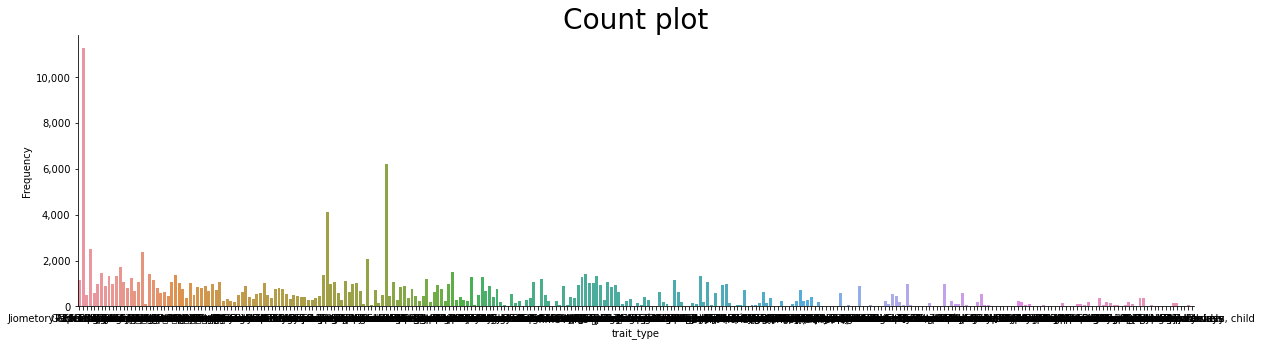

In [17]:
barchar_bucket(df_sales_final,'trait_type')

In [18]:
def histo_plot(ds,n,p,b,cols=list):

    # Identify all numeric variables in the dataset
    numerical=ds.select_dtypes(include=[np.number]).columns.tolist()

    # Draw
    fig, ax = plt.subplots(n,p, figsize=(18,4))
    for var, subplot in zip(ds[cols], ax.flatten()):
        g = sns.histplot(data=ds,
                    bins=b,
                     x=var,
                     ax=subplot,
                     kde=True)

    # Decoration
    sns.despine()
    plt.rc('axes', labelsize=subPlots_label_fontSize)
    fig.suptitle("Histograms of all premium variables", fontsize=plots_Title_fontSize)

In [19]:
# Violin Plot
def violin_plot(ds,cols,hue_col,width,height, hue=False):

    for var in cols:
        if hue is False:
            fig = px.violin(ds, y=var, box=True, points= False)
        else:
            fig = px.violin(ds, y=var, box=True, points= False, color=hue_col)

        fig.update_layout(height=height, width=width, title_text='Violin Plot of '+ var, template = "plotly_white")
        fig.show()
        

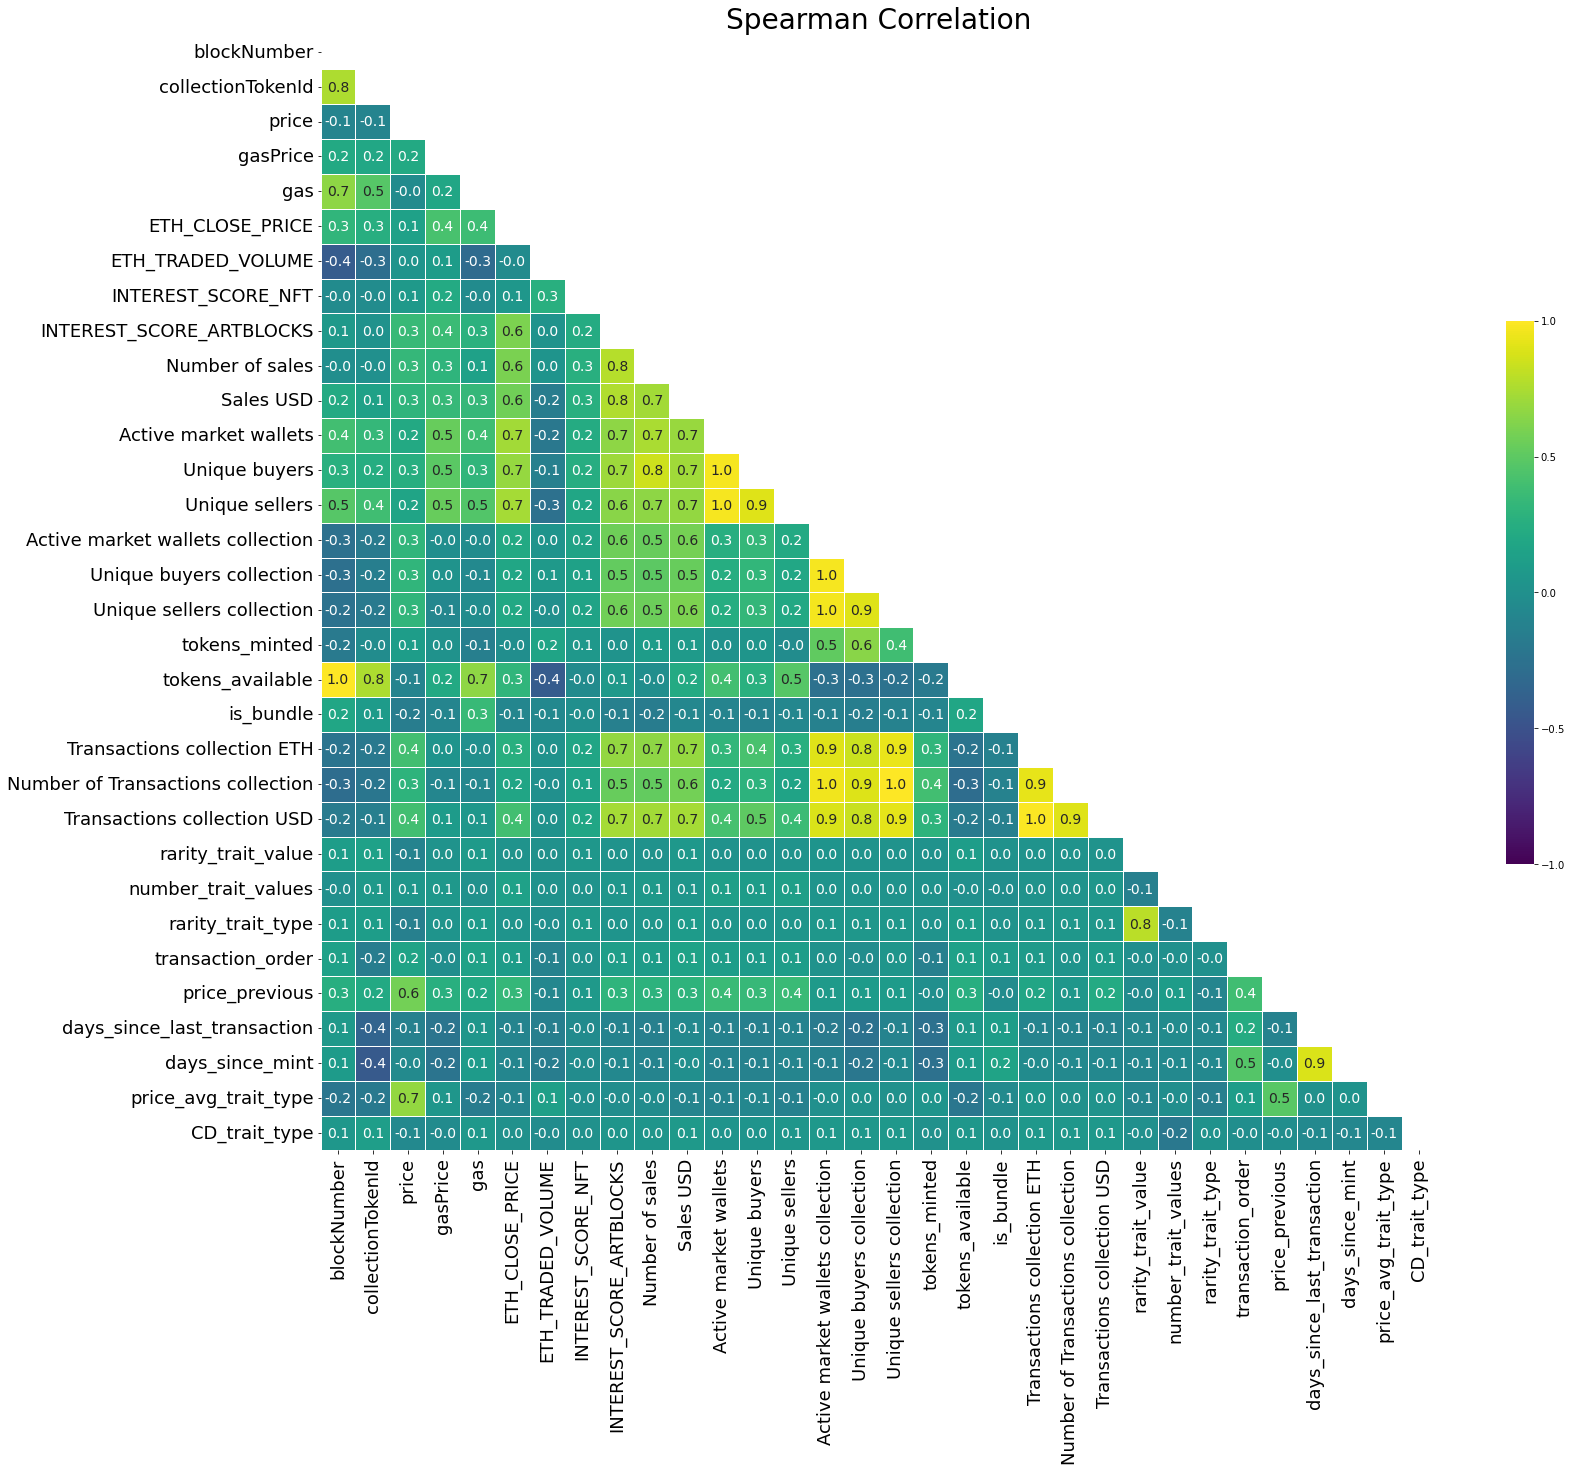

In [20]:
# CORRELATION

# Create correlation matrix
corr = df_sales_final.corr(method='spearman')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

# Draw
fig , ax = plt.subplots(figsize=(25, 25))
heatmap = sns.heatmap(corr,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'viridis',
                      cbar_kws = {'shrink': .4,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      fmt='.1f',
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': heatmaps_text_fontSize})

# Decoration
plt.title("Spearman Correlation", fontsize=plots_Title_fontSize)
ax.set_yticklabels(corr.columns, rotation = 0, fontsize=18)
ax.set_xticklabels(corr.columns, rotation = 90, fontsize=18)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

In [21]:
# Get correlated features
c = df_sales_final.corr(method='spearman').abs()
s = c.unstack()
so = s.sort_values(kind="quicksort")
so = so[so > 0.5]
so.sort_values(ascending=False,inplace=True)
df_so = pd.DataFrame(so)
df_so = df_so.reset_index()
df_so = df_so[df_so['level_0']!=df_so['level_1']]
df_so.drop_duplicates(subset=[0],inplace=True)
df_so

,level_0,level_1,0
32,blockNumber,tokens_available,0.999936
34,Unique sellers collection,Number of Transactions collection,0.992600
36,Transactions collection USD,Transactions collection ETH,0.987200
38,Unique buyers collection,Active market wallets collection,0.972240
40,Unique sellers,Active market wallets,0.971930
...,...,...,...
156,Unique sellers,gasPrice,0.531596
158,INTEREST_SCORE_ARTBLOCKS,Unique buyers collection,0.522614
160,Number of Transactions collection,Number of sales,0.517899
162,tokens_minted,Active market wallets collection,0.513769


In [22]:
'''# CORRELATION

# Create correlation matrix
corr = df_model_final.corr(method='spearman')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

# Draw
fig , ax = plt.subplots(figsize=(25, 25))
heatmap = sns.heatmap(corr,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'viridis',
                      cbar_kws = {'shrink': .4,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      fmt='.1f',
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': heatmaps_text_fontSize})

# Decoration
plt.title("Spearman Correlation", fontsize=plots_Title_fontSize)
ax.set_yticklabels(corr.columns, rotation = 0, fontsize=18)
ax.set_xticklabels(corr.columns, rotation = 90, fontsize=18)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})'''

'# CORRELATION\n\n# Create correlation matrix\ncorr = df_model_final.corr(method=\'spearman\')\nmask = np.zeros_like(corr, dtype=np.bool)\nmask[np.triu_indices_from(mask)]= True\n\n# Draw\nfig , ax = plt.subplots(figsize=(25, 25))\nheatmap = sns.heatmap(corr,\n                      mask = mask,\n                      square = True,\n                      linewidths = .5,\n                      cmap = \'viridis\',\n                      cbar_kws = {\'shrink\': .4,\n                                \'ticks\' : [-1, -.5, 0, 0.5, 1]},\n                      fmt=\'.1f\',\n                      vmin = -1,\n                      vmax = 1,\n                      annot = True,\n                      annot_kws = {\'size\': heatmaps_text_fontSize})\n\n# Decoration\nplt.title("Spearman Correlation", fontsize=plots_Title_fontSize)\nax.set_yticklabels(corr.columns, rotation = 0, fontsize=18)\nax.set_xticklabels(corr.columns, rotation = 90, fontsize=18)\nsns.set_style({\'xtick.bottom\': True}, {\'ytic

In [23]:
def scatter_matrix(title,ds,cols,hue_col,hue=False):
    
    if hue is False:
        fig = px.scatter_matrix(ds,dimensions=cols)        
    else:
        fig = px.scatter_matrix(ds,dimensions=cols,color=hue_col)
    
    fig.update_layout(height=1200, width=1200, title_text='Scatter Matrix - '+title)#, template = "plotly_white")
    fig.show()

In [24]:
df_sales_final.columns

Index(['blockNumber', 'DATETIME', 'from', 'to', 'txHash', 'collectionTokenId',
       'hash', 'price', 'gasPrice', 'gas', 'DATE', 'ETH_CLOSE_PRICE',
       'ETH_TRADED_VOLUME', 'INTEREST_SCORE_NFT', 'INTEREST_SCORE_ARTBLOCKS',
       'Number of sales', 'Sales USD', 'Active market wallets',
       'Unique buyers', 'Unique sellers', 'Active market wallets collection',
       'Unique buyers collection', 'Unique sellers collection',
       'tokens_minted', 'tokens_available', 'Action', 'is_bundle',
       'Transactions collection ETH', 'Number of Transactions collection',
       'Transactions collection USD', 'trait_type', 'rarity_trait_value',
       'number_trait_values', 'rarity_trait_type', 'transaction_order',
       'price_previous', 'days_since_last_transaction', 'days_since_mint',
       'price_avg_trait_type', 'CD_trait_type'],
      dtype='object')

## Feature Selection

In [25]:
# Add date features
df_sales_final['DATE_WEEKDAY'] = df_sales_final['DATE'].dt.weekday
df_sales_final['DATE_MONTH'] = df_sales_final['DATE'].dt.month
df_sales_final['DATE_YEAR'] = df_sales_final['DATE'].dt.year

final_columns =  ['DATE_WEEKDAY','DATE_MONTH','DATE_YEAR','DATEYEAR','DATE','CD_trait_type',
                  'INTEREST_SCORE_NFT','INTEREST_SCORE_ARTBLOCKS','price', 'gasPrice',
                  'tokens_available','ETH_TRADED_VOLUME','ETH_CLOSE_PRICE','Sales USD','Active market wallets', #delta
                 'Transactions collection USD','Unique buyers collection','Unique sellers collection', #delta
                 'rarity_trait_value', 'number_trait_values','rarity_trait_type','trait_type',
                 'Number of Transactions collection','Active market wallets collection','Number of sales','Unique buyers', 'Unique sellers'
                 ,'is_bundle','transaction_order', 'price_previous','days_since_last_transaction', 'days_since_mint','price_avg_trait_type']

delta_cols = ['ETH_TRADED_VOLUME','ETH_CLOSE_PRICE','Sales USD','Active market wallets', #delta
                 'Transactions collection USD','Unique buyers collection','Unique sellers collection','tokens_available',
             'Number of Transactions collection','Active market wallets collection','Number of sales','Unique buyers','Unique sellers'
             ]

In [28]:
df_sales_final['DATEYEAR'] = df_sales_final['DATE_YEAR']
df_model = df_sales_final[final_columns]
df_model.sort_values(by='DATE',inplace=True)

# Add quarter variables
df_model['DATE_QUARTER'] = df_model.DATE.dt.quarter
df_model = pd.get_dummies(df_model, columns=['DATE_QUARTER'])

# Add year dummies
df_model = pd.get_dummies(df_model, columns=['DATE_YEAR'])

## Get delta data
df_delta = df_model[['DATE'] + delta_cols].drop_duplicates()
df_delta.sort_values(by='DATE',inplace=True)

df_delta_1 = df_delta.copy()
df_delta_1.index = df_delta_1.DATE 

df_delta_1 = df_delta_1.shift(periods=1)
df_delta_1.DATE = df_delta_1.index
df_delta_1.reset_index(drop=True,inplace=True)

df_delta = df_delta.merge(df_delta_1, how='left', on=['DATE'], suffixes=('', '_1'),indicator=False)
#df_delta.fillna(0,inplace=True)

deltas = []
for col in delta_cols:
    deltas.append(col+'_DELTA')
        
    for i in range(0,df_delta.index.max()+1):
        #print(i,col)
        t = df_delta.loc[i,col]
        t_1 = df_delta.loc[i,col+'_1']
        if i==0:
            pass
        else:
            df_delta.loc[i,col+'_DELTA'] = (t - t_1)/t_1
            

# Add deltas to main dataset
df_model_ = df_model.merge(df_delta[['DATE']+deltas], how='left', on=['DATE'], suffixes=('', ''),indicator=False)
df_model_.dropna(inplace=True)
df_model_.sort_values(by='DATE',inplace=True)

# Filter the deltas
final_columns_ =  ['DATE_WEEKDAY','DATE_MONTH','DATE','DATEYEAR','DATE_YEAR_2020', 'DATE_YEAR_2021', 'DATE_YEAR_2022',
                  'INTEREST_SCORE_NFT','INTEREST_SCORE_ARTBLOCKS','price', 'gasPrice','is_bundle',
                 'rarity_trait_value', 'number_trait_values','rarity_trait_type'
                  ,'transaction_order', 'price_previous','days_since_last_transaction', 'days_since_mint',
                   'price_avg_trait_type','DATE_QUARTER_1','DATE_QUARTER_3','DATE_QUARTER_3','DATE_QUARTER_4'
                  ] + deltas
df_model_final = df_model_[final_columns_]
df_model_final.sort_values(by='DATE',inplace=True)

In [31]:
df_model_final.columns

Index(['DATE_WEEKDAY', 'DATE_MONTH', 'DATE', 'DATEYEAR', 'DATE_YEAR_2020',
       'DATE_YEAR_2021', 'DATE_YEAR_2022', 'INTEREST_SCORE_NFT',
       'INTEREST_SCORE_ARTBLOCKS', 'price', 'gasPrice', 'is_bundle',
       'rarity_trait_value', 'number_trait_values', 'rarity_trait_type',
       'transaction_order', 'price_previous', 'days_since_last_transaction',
       'days_since_mint', 'price_avg_trait_type', 'DATE_QUARTER_1',
       'DATE_QUARTER_3', 'DATE_QUARTER_3', 'DATE_QUARTER_4',
       'ETH_TRADED_VOLUME_DELTA', 'ETH_CLOSE_PRICE_DELTA', 'Sales USD_DELTA',
       'Active market wallets_DELTA', 'Transactions collection USD_DELTA',
       'Unique buyers collection_DELTA', 'Unique sellers collection_DELTA',
       'tokens_available_DELTA', 'Number of Transactions collection_DELTA',
       'Active market wallets collection_DELTA', 'Number of sales_DELTA',
       'Unique buyers_DELTA', 'Unique sellers_DELTA'],
      dtype='object')

In [33]:
df_model_final

,DATE_WEEKDAY,DATE_MONTH,DATE,DATEYEAR,DATE_YEAR_2020,DATE_YEAR_2021,DATE_YEAR_2022,INTEREST_SCORE_NFT,INTEREST_SCORE_ARTBLOCKS,price,...,Active market wallets_DELTA,Transactions collection USD_DELTA,Unique buyers collection_DELTA,Unique sellers collection_DELTA,tokens_available_DELTA,Number of Transactions collection_DELTA,Active market wallets collection_DELTA,Number of sales_DELTA,Unique buyers_DELTA,Unique sellers_DELTA
19,0,12,2020-12-14,2020,1,0,0,10.5,33.0,0.049,...,-0.187587,-0.827748,-0.578947,-0.166667,0.014060,-0.684211,-0.531915,-0.191496,-0.192337,-0.226766
20,0,12,2020-12-14,2020,1,0,0,10.5,33.0,0.330,...,-0.187587,-0.827748,-0.578947,-0.166667,0.014060,-0.684211,-0.531915,-0.191496,-0.192337,-0.226766
21,0,12,2020-12-14,2020,1,0,0,10.5,33.0,0.049,...,-0.187587,-0.827748,-0.578947,-0.166667,0.014060,-0.684211,-0.531915,-0.191496,-0.192337,-0.226766
22,0,12,2020-12-14,2020,1,0,0,10.5,33.0,0.090,...,-0.187587,-0.827748,-0.578947,-0.166667,0.014060,-0.684211,-0.531915,-0.191496,-0.192337,-0.226766
23,0,12,2020-12-14,2020,1,0,0,10.5,33.0,0.050,...,-0.187587,-0.827748,-0.578947,-0.166667,0.014060,-0.684211,-0.531915,-0.191496,-0.192337,-0.226766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148887,3,6,2022-06-30,2022,0,0,1,22.0,21.0,0.150,...,0.027995,-0.873286,-0.643678,-0.520349,0.001313,-0.690751,-0.522857,-0.094595,-0.025663,0.055688
148888,3,6,2022-06-30,2022,0,0,1,22.0,21.0,0.180,...,0.027995,-0.873286,-0.643678,-0.520349,0.001313,-0.690751,-0.522857,-0.094595,-0.025663,0.055688
148836,3,6,2022-06-30,2022,0,0,1,22.0,21.0,0.190,...,0.027995,-0.873286,-0.643678,-0.520349,0.001313,-0.690751,-0.522857,-0.094595,-0.025663,0.055688
148784,3,6,2022-06-30,2022,0,0,1,22.0,21.0,0.500,...,0.027995,-0.873286,-0.643678,-0.520349,0.001313,-0.690751,-0.522857,-0.094595,-0.025663,0.055688


_________

## Modeling

### OLS

In [47]:
# Split into train and test
def split_ts(df,cols,tgt):
    
    df_ = df[cols]

    test_size = int(round(len(df_)*0.20,0))
    size = int(len(df_) - test_size)
    test = df_.iloc[-test_size:]
    train = df_.iloc[:size]

    
    X_train = train.drop(columns=[tgt])
    X_test = test.drop(columns=[tgt])
    y_train = train[tgt]
    y_test = test[tgt]
        
    return df_, X_train, X_test, y_train, y_test


In [148]:
def build_ols(df_model,cols):
    
    # No delta variables
    df_ols = df_model.copy()
    
    df_ols['ln_price'] = np.log(df_ols['price'])
    df_ols, X_train, X_test, y_train, y_test = split_ts(df_ols,cols,'ln_price')

    Y = y_train#df_ols['ln_price']
    X = X_train.drop(columns=['price'])
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    results = model.fit()

    predictions = results.predict(X)
    df_pred = pd.DataFrame(predictions)
    df_pred.rename(columns={0: "y_hat"},inplace=True)
    df_pred['y_hat'] = np.exp(df_pred['y_hat'])
    df_pred['y'] = np.exp(Y)

    mape = mean_absolute_percentage_error(df_pred['y'], df_pred['y_hat'])
    mae = mean_absolute_error(df_pred['y'], df_pred['y_hat'])
    mse = mean_squared_error(df_pred['y'], df_pred['y_hat'])
    print('------------ TRAINING RESULTS ------------')
    print('MAPE: ', mape)
    print('MAE: ', mae)
    print('MSE: ', mse)

    # Testing
    Y = y_test#df_ols['ln_price']
    X_ = X_test.drop(columns=['price'])
    X_['const'] = results.params[0] #sm.add_constant(X_)
    
    predictions = results.predict(X_)
    #predictions = results.get_prediction(X_).summary_frame(alpha=0.05)
    df_pred = pd.DataFrame(predictions)
    df_pred.rename(columns={0: "y_hat"},inplace=True)
    df_pred['y_hat'] = np.exp(df_pred['y_hat'])
    df_pred['y'] = np.exp(Y)
    #df_pred['y'] = Y
    
    mape = mean_absolute_percentage_error(df_pred['y'], df_pred['y_hat'])
    mae = mean_absolute_error(df_pred['y'], df_pred['y_hat'])
    mse = mean_squared_error(df_pred['y'], df_pred['y_hat'])
    r2 = r2_score(df_pred['y'], df_pred['y_hat'])
    
    print('------------ TESTING RESULTS ------------')
    print('MAPE: ', mape)
    print('MAE: ', mae)
    print('MSE: ', mse)
    print('R2: ', r2)
    
    return results,df_pred


In [151]:
# No delta variables
cols = ['INTEREST_SCORE_NFT','INTEREST_SCORE_ARTBLOCKS','gasPrice', 'rarity_trait_value', 'number_trait_values',
       'rarity_trait_type', 'ETH_TRADED_VOLUME', 'ETH_CLOSE_PRICE',
       'Sales USD', 'Active market wallets', 
       'Transactions collection USD', 'Unique buyers collection',
            'Number of Transactions collection','Active market wallets collection','Number of sales','Unique buyers', 'Unique sellers', #
       'Unique sellers collection', 'tokens_available','DATE_QUARTER_1','DATE_QUARTER_3','DATE_QUARTER_3','DATE_QUARTER_4',
           'DATE_YEAR_2020', 'DATE_YEAR_2021', 'DATE_YEAR_2022','is_bundle'
            , 'price_previous','days_since_last_transaction', 'days_since_mint','price_avg_trait_type','price','ln_price'
           ]
results,predictions = build_ols(df_model,cols)
results.summary()


------------ TRAINING RESULTS ------------
MAPE:  10865871939.025976
MAE:  780.3460878874413
MSE:  54889989354.41942
------------ TESTING RESULTS ------------
MAPE:  0.9999665694002158
MAE:  1.058530901311851
MSE:  25.565306804559043
R2:  -0.045837429306385014


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     3639.
Date:                Fri, 29 Jul 2022   Prob (F-statistic):               0.00
Time:                        23:37:03   Log-Likelihood:            -1.8821e+05
No. Observations:              119113   AIC:                         3.765e+05
Df Residuals:                  119084   BIC:                         3.768e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -1.8200      0.034    -53.947      0.000      -1.886      -1.754
INTEREST_SCORE_NFT                   -0.0054      0.001     -8.356      0.000      -0.007      -0.004
INTEREST_SCORE_ARTBLOCKS              0.0139      0.000     35.637      0.000       0.013       0.015
gasPrice                           2.661e-07   3.79e-09     70.120      0.000    2.59e-07    2.73e-07
rarity_trait_value                    6.6967      0.103     64.939      0.000       6.495       6.899
number_trait_values                   0.0235      0.001     44.515      0.000       0.022       0.025
rarity_trait_type                    -0.7483      0.008    -88.694      0.000      -0.765      -0.732
ETH_TRADED_VOLUME                 -1.017e-12   7.61e-13     -1.337      0.181   -2.51e-12    4.74e-13
ETH_CLOSE_PRICE                    4.431e-05    1.3e-05      3.418      0.001    1.89e-05    6.97e-05
Sales USD                          4.937e-10   8.77e-11      5.627      0.000    3.22e-10    6.66e-10
Active market wallets             -1.599e-05   7.13e-06     -2.243      0.025      -3e-05   -2.02e-06
Transactions collection USD       -6.792e-09   8.08e-10     -8.409      0.000   -8.38e-09   -5.21e-09
Unique buyers collection              0.0007   3.67e-05     19.857      0.000       0.001       0.001
Number of Transactions collection    -0.0007   2.49e-05    -28.357      0.000      -0.001      -0.001
Active market wallets collection     -0.0007   4.93e-05    -13.919      0.000      -0.001      -0.001
Number of sales                    4.098e-06   3.21e-07     12.768      0.000    3.47e-06    4.73e-06
Unique buyers                      7.657e-06   6.63e-06      1.155      0.248   -5.34e-06    2.07e-05
Unique sellers                     2.312e-05   4.79e-06      4.823      0.000    1.37e-05    3.25e-05
Unique sellers collection             0.0018   7.35e-05     24.362      0.000       0.002       0.002
tokens_available                  -6.433e-06   5.19e-07    -12.397      0.000   -7.45e-06   -5.42e-06
DATE_QUARTER_1                        0.7725      0.024     32.741      0.000       0.726       0.819
DATE_QUARTER_3                        0.2950      0.012     24.803      0.000       0.272       0.318
DATE_QUARTER_3                        0.2950      0.012     24.803      0.000       0.272       0.318
DATE_QUARTER_4                        0.2509      0.035      7.193      0.000       0.183       0.319
DATE_YEAR_2020                       -0.8746      0.087    -10.072      0.000      -1.045      -0.704
DATE_YEAR_2021                       -0.2852      0.030     -9.621      0.000      -0.343      -0.227
DATE_YEAR_2022                       -0.6601      0.054    -12.230      0.000      -0.766      -0.554
is_bundle              

In [ ]:
# No delta variables
df_ols = df_model.copy()
df_ols['ln_price'] = np.log(df_ols['price'])


Y = df_ols['ln_price']

X = df_ols[['INTEREST_SCORE_NFT','INTEREST_SCORE_ARTBLOCKS','gasPrice', 'rarity_trait_value', 'number_trait_values',
       'rarity_trait_type', 'ETH_TRADED_VOLUME', 'ETH_CLOSE_PRICE',
       'Sales USD', 'Active market wallets', 
       'Transactions collection USD', 'Unique buyers collection',
            'Number of Transactions collection','Active market wallets collection','Number of sales','Unique buyers', 'Unique sellers', #
       'Unique sellers collection', 'tokens_available',
           'DATE_YEAR_2020', 'DATE_YEAR_2021', 'DATE_YEAR_2022','is_bundle'
            , 'price_previous','days_since_last_transaction', 'days_since_mint','price_avg_trait_type'
           ]]


X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()

predictions = results.predict(X)
df_pred = pd.DataFrame(predictions)
df_pred.rename(columns={0: "y_hat"},inplace=True)
df_pred['y'] = Y
df_pred

mape = mean_absolute_percentage_error(df_pred['y'], df_pred['y_hat'])
mae = mean_absolute_error(df_pred['y'], df_pred['y_hat'])
mse = mean_squared_error(df_pred['y'], df_pred['y_hat'])
print('MAPE: ', mape)
print('MAE: ', mae)
print('MSE: ', mse)

results.summary()


MAPE:  56528330757989.58
MAE:  0.9088744940268655
MSE:  1.5435331426670937


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     4019.
Date:                Thu, 28 Jul 2022   Prob (F-statistic):               0.00
Time:                        16:50:36   Log-Likelihood:            -2.4358e+05
No. Observations:              148891   AIC:                         4.872e+05
Df Residuals:                  148865   BIC:                         4.875e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -1.3628      0.031    -43.395      0.000      -1.424      -1.301
INTEREST_SCORE_NFT                   -0.0019      0.000     -4.141      0.000      -0.003      -0.001
INTEREST_SCORE_ARTBLOCKS              0.0143      0.000     41.225      0.000       0.014       0.015
gasPrice                           3.287e-07   4.19e-09     78.431      0.000     3.2e-07    3.37e-07
rarity_trait_value                    7.4335      0.095     77.876      0.000       7.246       7.621
number_trait_values                   0.0226      0.000     45.873      0.000       0.022       0.024
rarity_trait_type                    -0.7737      0.008    -92.347      0.000      -0.790      -0.757
ETH_TRADED_VOLUME                 -1.594e-12   6.54e-13     -2.438      0.015   -2.88e-12   -3.13e-13
ETH_CLOSE_PRICE                      -0.0002   8.85e-06    -21.627      0.000      -0.000      -0.000
Sales USD                          1.321e-09   7.16e-11     18.443      0.000    1.18e-09    1.46e-09
Active market wallets             -3.364e-05   5.07e-06     -6.634      0.000   -4.36e-05   -2.37e-05
Transactions collection USD       -7.947e-09   7.63e-10    -10.410      0.000   -9.44e-09   -6.45e-09
Unique buyers collection              0.0007   3.44e-05     21.135      0.000       0.001       0.001
Number of Transactions collection    -0.0008    1.8e-05    -41.633      0.000      -0.001      -0.001
Active market wallets collection     -0.0008   4.78e-05    -16.021      0.000      -0.001      -0.001
Number of sales                    5.824e-06   2.74e-07     21.246      0.000    5.29e-06    6.36e-06
Unique buyers                      3.048e-05   4.94e-06      6.170      0.000    2.08e-05    4.02e-05
Unique sellers                     1.383e-05   3.81e-06      3.629      0.000    6.36e-06    2.13e-05
Unique sellers collection             0.0021   6.33e-05     32.827      0.000       0.002       0.002
tokens_available                  -1.292e-06   2.01e-07     -6.414      0.000   -1.69e-06   -8.97e-07
DATE_YEAR_2020                       -1.1763      0.082    -14.350      0.000      -1.337      -1.016
DATE_YEAR_2021                       -0.1953      0.030     -6.573      0.000      -0.254      -0.137
DATE_YEAR_2022                        0.0089      0.032      0.275      0.784      -0.054       0.072
is_bundle                            -1.6383      0.017    -96.722      0.000      -1.671      -1.605
price_previous                        0.0337      0.001     40.603      0.000       0.032       0.035
days_since_last_transaction          -0.0034   9.47e-05    -35.409      0.000      -0.004      -0.003
days_since_mint                       0.0036   7.74e-05     45.946      0.000       0.003       0.004
price_avg_trait_type   

In [ ]:
# both delta and non delta variables
df_ols = df_model_.copy()
df_ols['ln_price'] = np.log(df_ols['price'])


Y = df_ols['ln_price']
X = df_ols[['INTEREST_SCORE_NFT','INTEREST_SCORE_ARTBLOCKS','gasPrice', 'rarity_trait_value', 'number_trait_values',
       'rarity_trait_type', 'ETH_TRADED_VOLUME_DELTA', 'ETH_CLOSE_PRICE_DELTA',
       'Sales USD_DELTA', 'Active market wallets_DELTA',
       'Transactions collection USD_DELTA', 'Unique buyers collection_DELTA',
       'Unique sellers collection_DELTA', 'tokens_available_DELTA',
    'Number of Transactions collection_DELTA','Active market wallets collection_DELTA','Number of sales_DELTA','Unique buyers_DELTA', 'Unique sellers_DELTA', #
        'ETH_TRADED_VOLUME', 'ETH_CLOSE_PRICE',
       'Sales USD', 'Active market wallets', 
       'Transactions collection USD', 'Unique buyers collection',
       'Unique sellers collection', 'tokens_available' ,  
           'DATE_YEAR_2020', 'DATE_YEAR_2021', 'DATE_YEAR_2022','is_bundle',
             'price_previous','days_since_last_transaction', 'days_since_mint','price_avg_trait_type'
           ]]


X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()

predictions = results.predict(X)
df_pred = pd.DataFrame(predictions)
df_pred.rename(columns={0: "y_hat"},inplace=True)
df_pred['y'] = Y
df_pred

mape = mean_absolute_percentage_error(df_pred['y'], df_pred['y_hat'])
mae = mean_absolute_error(df_pred['y'], df_pred['y_hat'])
mse = mean_squared_error(df_pred['y'], df_pred['y_hat'])
print('MAPE: ', mape)
print('MAE: ', mae)
print('MSE: ', mse)

results.summary()

MAPE:  54781769538221.7
MAE:  0.913797149497816
MSE:  1.5673995480836287


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     2929.
Date:                Thu, 28 Jul 2022   Prob (F-statistic):               0.00
Time:                        16:50:36   Log-Likelihood:            -2.4469e+05
No. Observations:              148872   AIC:                         4.895e+05
Df Residuals:                  148838   BIC:                         4.898e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                      -1.2324      0.034    -36.198      0.000      -1.299      -1.166
INTEREST_SCORE_NFT                         -0.0003      0.000     -0.617      0.537      -0.001       0.001
INTEREST_SCORE_ARTBLOCKS                    0.0155      0.000     45.547      0.000       0.015       0.016
gasPrice                                 6.307e-08   9.22e-08      0.684      0.494   -1.18e-07    2.44e-07
rarity_trait_value                          7.2878      0.096     75.852      0.000       7.099       7.476
number_trait_values                         0.0216      0.000     43.619      0.000       0.021       0.023
rarity_trait_type                          -0.7500      0.008    -89.020      0.000      -0.767      -0.733
ETH_TRADED_VOLUME_DELTA                     0.0414      0.015      2.748      0.006       0.012       0.071
ETH_CLOSE_PRICE_DELTA                       0.8088      0.079     10.224      0.000       0.654       0.964
Sales USD_DELTA                            -0.2033      0.010    -20.789      0.000      -0.222      -0.184
Active market wallets_DELTA                -1.7130      0.241     -7.114      0.000      -2.185      -1.241
Transactions collection USD_DELTA           0.0069      0.000     17.246      0.000       0.006       0.008
Unique buyers collection_DELTA             -0.1085      0.008    -14.207      0.000      -0.124      -0.094
Unique sellers collection_DELTA             0.3662      0.012     29.716      0.000       0.342       0.390
tokens_available_DELTA                     -0.4188      0.448     -0.935      0.350      -1.297       0.459
Number of Transactions collection_DELTA    -0.1369      0.006    -24.131      0.000      -0.148      -0.126
Active market wallets collection_DELTA      0.1661      0.018      9.227      0.000       0.131       0.201
Number of sales_DELTA                       0.2855      0.034      8.456      0.000       0.219       0.352
Unique buyers_DELTA                         0.8956      0.151      5.933      0.000       0.600       1.192
Unique sellers_DELTA                        0.2569      0.088      2.906      0.004       0.084       0.430
ETH_TRADED_VOLUME                       -2.136e-14    7.5e-13     -0.028      0.977   -1.49e-12    1.45e-12
ETH_CLOSE_PRICE                            -0.0004   8.61e-06    -43.575      0.000      -0.000      -0.000
Sales USD                                2.954e-09   7.88e-11     37.483      0.000     2.8e-09    3.11e-09
Active market wallets                    8.089e-06    3.5e-07     23.110      0.000     7.4e-06    8.77e-06
Transactions collection USD             -3.735e-10   7.86e-10     -0.475      0.635   -1.91e-09    1.17e-09
Unique buyers collection                    0.0003    1.4e-

In [ ]:
# Only delta variables

df_ols = df_model_final.copy()
df_ols['ln_price'] = np.log(df_ols['price'])


Y = df_ols['ln_price']
X = df_ols[['INTEREST_SCORE_NFT','INTEREST_SCORE_ARTBLOCKS','gasPrice', 'rarity_trait_value', 'number_trait_values',
       'rarity_trait_type', 'ETH_TRADED_VOLUME_DELTA', 'ETH_CLOSE_PRICE_DELTA',
       'Sales USD_DELTA', 'Active market wallets_DELTA',
    'Number of Transactions collection_DELTA','Active market wallets collection_DELTA','Number of sales_DELTA','Unique buyers_DELTA', 'Unique sellers_DELTA', #            
       'Transactions collection USD_DELTA', 'Unique buyers collection_DELTA',
       'Unique sellers collection_DELTA', 'tokens_available_DELTA',
           'DATE_YEAR_2020', 'DATE_YEAR_2021', 'DATE_YEAR_2022','is_bundle'
            , 'price_previous','days_since_last_transaction', 'days_since_mint','price_avg_trait_type'
           ]]


X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()

predictions = results.predict(X)
df_pred = pd.DataFrame(predictions)
df_pred.rename(columns={0: "y_hat"},inplace=True)
df_pred['y'] = Y
df_pred

mape = mean_absolute_percentage_error(df_pred['y'], df_pred['y_hat'])
mae = mean_absolute_error(df_pred['y'], df_pred['y_hat'])
mse = mean_squared_error(df_pred['y'], df_pred['y_hat'])
print('MAPE: ', mape)
print('MAE: ', mae)
print('MSE: ', mse)

results.summary()

MAPE:  54380131329795.305
MAE:  0.9287201885823327
MSE:  1.6131799671397395


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     3450.
Date:                Thu, 28 Jul 2022   Prob (F-statistic):               0.00
Time:                        16:50:37   Log-Likelihood:            -2.4684e+05
No. Observations:              148872   AIC:                         4.937e+05
Df Residuals:                  148845   BIC:                         4.940e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                      -1.8911      0.032    -59.668      0.000      -1.953      -1.829
INTEREST_SCORE_NFT                          0.0053      0.000     13.399      0.000       0.005       0.006
INTEREST_SCORE_ARTBLOCKS                    0.0214      0.000    138.646      0.000       0.021       0.022
gasPrice                                 9.246e+05   4.13e+04     22.405      0.000    8.44e+05    1.01e+06
rarity_trait_value                          7.0271      0.097     72.759      0.000       6.838       7.216
number_trait_values                         0.0183      0.000     36.977      0.000       0.017       0.019
rarity_trait_type                          -0.7307      0.009    -85.773      0.000      -0.747      -0.714
ETH_TRADED_VOLUME_DELTA                     0.1088      0.013      8.134      0.000       0.083       0.135
ETH_CLOSE_PRICE_DELTA                       0.3613      0.079      4.592      0.000       0.207       0.516
Sales USD_DELTA                            -0.0215      0.008     -2.541      0.011      -0.038      -0.005
Active market wallets_DELTA                -2.1063      0.242     -8.703      0.000      -2.581      -1.632
Number of Transactions collection_DELTA    -0.1834      0.006    -32.898      0.000      -0.194      -0.172
Active market wallets collection_DELTA      0.0775      0.018      4.381      0.000       0.043       0.112
Number of sales_DELTA                       0.1773      0.033      5.386      0.000       0.113       0.242
Unique buyers_DELTA                         1.2231      0.150      8.128      0.000       0.928       1.518
Unique sellers_DELTA                        0.4674      0.089      5.240      0.000       0.293       0.642
Transactions collection USD_DELTA           0.0088      0.000     21.738      0.000       0.008       0.010
Unique buyers collection_DELTA             -0.0706      0.007     -9.556      0.000      -0.085      -0.056
Unique sellers collection_DELTA             0.4273      0.012     36.124      0.000       0.404       0.450
tokens_available_DELTA                      8.8022      0.272     32.418      0.000       8.270       9.334
DATE_YEAR_2020                             -1.1824      0.090    -13.105      0.000      -1.359      -1.006
DATE_YEAR_2021                             -0.2992      0.031     -9.669      0.000      -0.360      -0.239
DATE_YEAR_2022                             -0.4094      0.031    -13.046      0.000      -0.471      -0.348
is_bundle                                  -1.6885      0.017    -98.651      0.000      -1.722      -1.655
price_previous                              0.0330      0.001     39.159      0.000       0.031       0.035
days_since_last_transaction                -0.0038   9.65e-

________________

___________________

In [ ]:
df_model.to_excel('df_model.xlsx')

In [ ]:
##### DEBUG #####
a = df_transactions[df_transactions['collectionTokenId']==78000313]
a.sort_values(by='DATETIME', ascending=True,inplace=True)
a

df_transactions[df_transactions['DATE']==pd.to_datetime('2020-12-13')]